# Step 2: Pre-processing - Spatial Filtering 🗺️

Once I have downloaded my datasets, the next step is to apply **spatial filtering**. This allows me to focus my model on a specific region by applying a geographic mask. You can filter datasets using geometries, which can range from simple polygons to more complex ones that include multiple polygons or holes.

For my example, I downloaded the geometries of **Skagerrak**, **Kattegat**, and the **Sweden Exclusive Economic Zone (EEZ)** from the [Marine Regions website](https://marineregions.org) in **.JSON** format:

- 🔗 [Sweden EEZ](https://www.marineregions.org/gazetteer.php?p=details&id=5694)
- 🔗 [Kattegat](https://marineregions.org/gazetteer.php?p=details&id=2374)
- 🔗 [Skagerrak](https://www.marineregions.org/gazetteer.php/gazetteer.php?p=details&id=2379)

I intend to cover the entire **Sweden EEZ** for the final model. However, to save time in the development process, I will first focus on a smaller region: the **Living Lab West**. This means I will combine the geometries of **Kattegat** and **Skagerrak**, and then filter this combined geometry using the **Sweden EEZ** geometry.

#### 📚 Required Libraries 
To perform this spatial filtering, you will need the following libraries:
- **`geopandas`**: For reading and manipulating spatial data.
- **`shapely`**: For geometric operations like union and intersection. 
- **`fiona`**: Used internally by geopandas to read .json files.
- **`matplotlib`**: For visualizing the data. 
- **`xarray`**: To handle and read the downloaded datasets. 
- **`numpy`**: For extracting latitude and longitude columns from the dataset. 

### 🛠️ Steps 
1. **Create the mask**: Load and combine the geometries, filter with the Sweden EEZ geometry and visualize the filtered geometry

2. **Filter the Zosteraceae dataset**: Load the files, identify the longitude and latitude columns, filter the points within the *livinglab_west* geometry, save and visualize the result.

3. **Filter the Baltic Sea Physics Reanalysis datset**: Load the files, identify the longitude and latitude columns, apply the mask of the *livinglab_west* geometry, save and visualize the results.

4. **Filter the Baltic Sea Biogeochemistry Reanalysis datset**: Repeat the method used to filter the Baltic Sea Physics Reanalysis datset.

5. **Filter the Bathymetry dataset**: Merge the 3 tiles of the dataset and filter using the previous methods.

____


### 🛠️ Create the mask

In [3]:
import geopandas as gpd

In [ ]:
# Load the geometries from the .json files
sweden_eez = gpd.read_file('sweden_eez.json')
kattegat = gpd.read_file('kattegat.json')
skagerrak = gpd.read_file('skagerrak.json')


💡 Make sure the CRS (Coordinate Reference System) is the same for all datasets. If needed, you can reproject them to the same CRS. For example :

`sweden_eez = sweden_eez.to_crs(epsg=4326)`

C:\Users\PC\AppData\Local\Temp\ipykernel_3732\1573077448.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined_geometry = kattegat.geometry.unary_union | skagerrak.geometry.unary_union  # Union of both geometries


<Axes: >

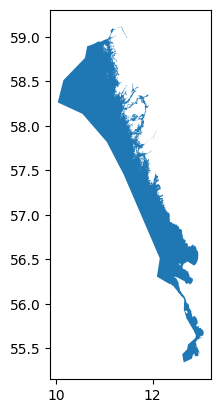

In [ ]:
# Combine Kattegat and Skagerrak geometries
combined_geometry = kattegat.geometry.unary_union | skagerrak.geometry.unary_union 

# Filter the combined geometry using the Sweden EEZ
filtered_geometry = sweden_eez.geometry.intersection(combined_geometry)

# Create a new GeoDataFrame with the filtered geometry
filtered_gdf = gpd.GeoDataFrame(geometry=filtered_geometry)

# Save the result to a new .json file
filtered_gdf.to_file('livinglab_west.json', driver='GeoJSON')

# Visualize the result
filtered_gdf.plot()

### 🛠️ Filtering the Zosteraceae dataset

In [4]:
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd

In [5]:
# Load the livinglab west geometry from the GeoJSON file
livinglab_geometry = gpd.read_file('livinglab_west.json')

In [ ]:
# Load the Artportalen CSV file into a pandas DataFrame
df = pd.read_csv('Artportalen-Zosteraceae.csv', delimiter ='\t')
print(df.columns)

Index(['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'infraspecificEpithet',
       'taxonRank', 'scientificName', 'verbatimScientificName',
       'verbatimScientificNameAuthorship', 'countryCode', 'locality',
       'stateProvince', 'occurrenceStatus', 'individualCount',
       'publishingOrgKey', 'decimalLatitude', 'decimalLongitude',
       'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation',
       'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day',
       'month', 'year', 'taxonKey', 'speciesKey', 'basisOfRecord',
       'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber',
       'identifiedBy', 'dateIdentified', 'license', 'rightsHolder',
       'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted',
       'mediaType', 'issue'],
      dtype='object')


💡 The spatial delimiter of the Artportalen dataset is a tab. 

I printed the columns of the dataframe to identify the longitude and latitude columns names: `'decimalLatitude'` and `'decimalLongitude'`

In [ ]:
# Define the geometry using longitude and latitude columns
points = [Point(xy) for xy in zip(df['decimalLongitude'], df['decimalLatitude'])]

# Convert the dataframe to a GeoDataFrame 
gdf_plants = gpd.GeoDataFrame(df, geometry=points)

# Make sure the CRS of Artportalen-Zosteraceae.csv matches the CRS of livinglab_ouest.json
gdf_plants = gdf_plants.set_crs('EPSG:4326', allow_override=True)

# Filter the points within the 'livinglab_ouest' geometry
filtered_gdf_plants = gdf_plants[gdf_plants.geometry.within(livinglab_geometry.unary_union)]

# Save the filtered data or work with it directly
filtered_gdf_plants.to_csv('filtered_Artportalen-Zosteraceae.csv', index=False)

C:\Users\PC\AppData\Local\Temp\ipykernel_3732\1857419964.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  filtered_gdf_plants = gdf_plants[gdf_plants.geometry.within(livinglab_geometry.unary_union)]


In [10]:
filtered_gdf_plants.geometry

0       POINT (11.56968 58.32986)
1       POINT (11.56968 58.32986)
2         POINT (11.4344 58.2674)
3       POINT (11.16944 58.79278)
4       POINT (12.53679 56.22762)
                  ...            
1112    POINT (12.53908 56.21715)
1113    POINT (12.91785 56.46712)
1114    POINT (11.78615 58.32873)
1115    POINT (11.76482 58.02897)
1116    POINT (12.93752 56.58907)
Name: geometry, Length: 1117, dtype: object

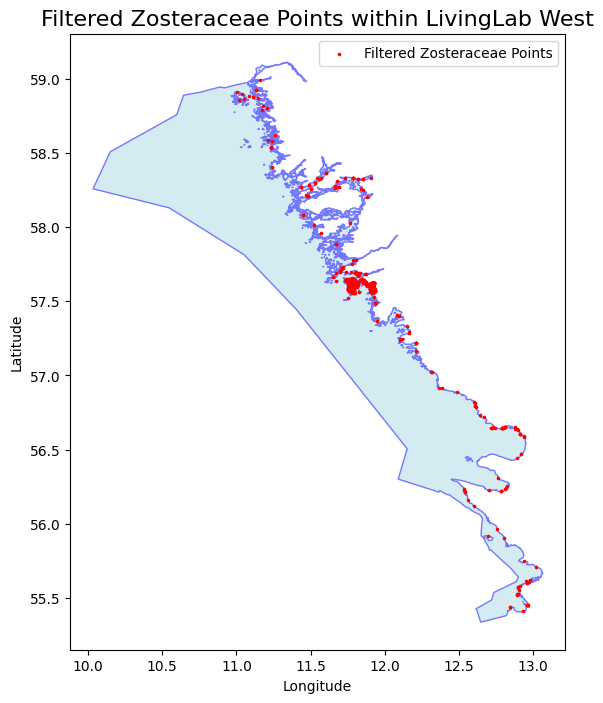

In [16]:
filtered_gdf_plants = pd.read_csv('filtered_Artportalen-Zosteraceae.csv')
filtered_gdf_plants = gpd.GeoDataFrame(filtered_gdf_plants, 
                                       geometry=gpd.points_from_xy(filtered_gdf_plants['decimalLongitude'], 
                                                                   filtered_gdf_plants['decimalLatitude']
                                                                   )
                                        )

# Plot the polygon and the filtered points
fig, ax = plt.subplots(figsize=(8, 8))
livinglab_geometry.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5)
filtered_gdf_plants.plot(ax=ax, marker='.', color='red', markersize=10, label="Filtered Zosteraceae Points")
ax.set_title('Filtered Zosteraceae Points within LivingLab West', fontsize=16)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

### 🛠️ Filtering the Baltic Sea Physics Reanalysis datset

Apply a spatial mask on a dataset is quite the same as apply it on a .csv file. I used the `xarray` library to read the .nc files, and `numpy` to extract the latitude and longitude colums.

In [2]:
import xarray as xr
import numpy as np
from shapely.geometry import shape

First, let's open one of the files and understand the structure of the file. In this file the longitude and columns names are `'lat'` and `'lon'`. There is also a column name `'depth'`

In [52]:
input_file = 'BAL-MYP-NEMO_PHY-AnnualMeans-2015.nc'
ds = xr.open_dataset(input_file)
ds

<xarray.Dataset> Size: 543MB
Dimensions:  (time: 1, lat: 774, lon: 763, depth: 56)
Coordinates:
  * depth    (depth) float32 224B 0.5016 1.516 2.548 3.602 ... 663.9 688.0 712.0
  * lat      (lat) float32 3kB 53.01 53.02 53.04 53.06 ... 65.86 65.87 65.89
  * lon      (lon) float32 3kB 9.042 9.069 9.097 9.125 ... 30.15 30.18 30.21
  * time     (time) datetime64[ns] 8B 2015-07-01T06:00:00
Data variables:
    bottomT  (time, lat, lon) float32 2MB ...
    mlotst   (time, lat, lon) float32 2MB ...
    siconc   (time, lat, lon) float32 2MB ...
    sithick  (time, lat, lon) float32 2MB ...
    sla      (time, lat, lon) float32 2MB ...
    so       (time, depth, lat, lon) float32 132MB ...
    sob      (time, lat, lon) float32 2MB ...
    thetao   (time, depth, lat, lon) float32 132MB ...
    uo       (time, depth, lat, lon) float32 132MB ...
    vo       (time, depth, lat, lon) float32 132MB ...
Attributes: (12/21)
    CDI:                    Climate Data Interface version 1.9.9rc1 (https://...
    Conventions:            CF-1.0
    history:                Tue Mar 07 17:51:07 2023: cdo cat /net/isilon/ifs...
    source:                 CMEMS BAL MFC NEMO model output converted to NetCDF
    institution:            Baltic MFC, PU Danish Meteorological Institute
    comment:                Data on cropped native product grid. Horizontal v...
    ...                     ...
    northernmost_latitude:  65.89099
    westernmost_longitude:  9.041542
    southernmost_latitude:  53.008297
    start_date:             2015-01-01 12:00:00
    CDO:                    Climate Data Operators version 1.9.9rc1 (https://...
    title:                  CMEMS NEMO annual integrated model fields

In [53]:
# Extract the coordinates from the NetCDF file
lat = ds['lat'].values
lon = ds['lon'].values

# Create a meshgrid of lat, lon
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Create a 2D array of coordinates
coords = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))

# Mask the points inside the livinglab ouest geometry
mask = np.array([livinglab_geometry.contains(shape({'type': 'Point', 'coordinates': (lon, lat)})) for lon, lat in coords])

# Reshape the mask to match the grid of the dataset
mask = mask.reshape(lon_grid.shape)

# Create an xarray DataArray for the mask with the correct dimensions and coordinates
mask_da = xr.DataArray(mask, coords=[ds['lat'], ds['lon']], dims=["lat", "lon"])

# Apply the mask to the NetCDF data variables
filtered_data = ds.where(mask_da, drop=True)

Let's check the data by creating 2 functions : 
- `plot_2D_variable` for variables with latitude and longitude
- `plot_3D_variable` for variables with latitude, longitude and **depth**.

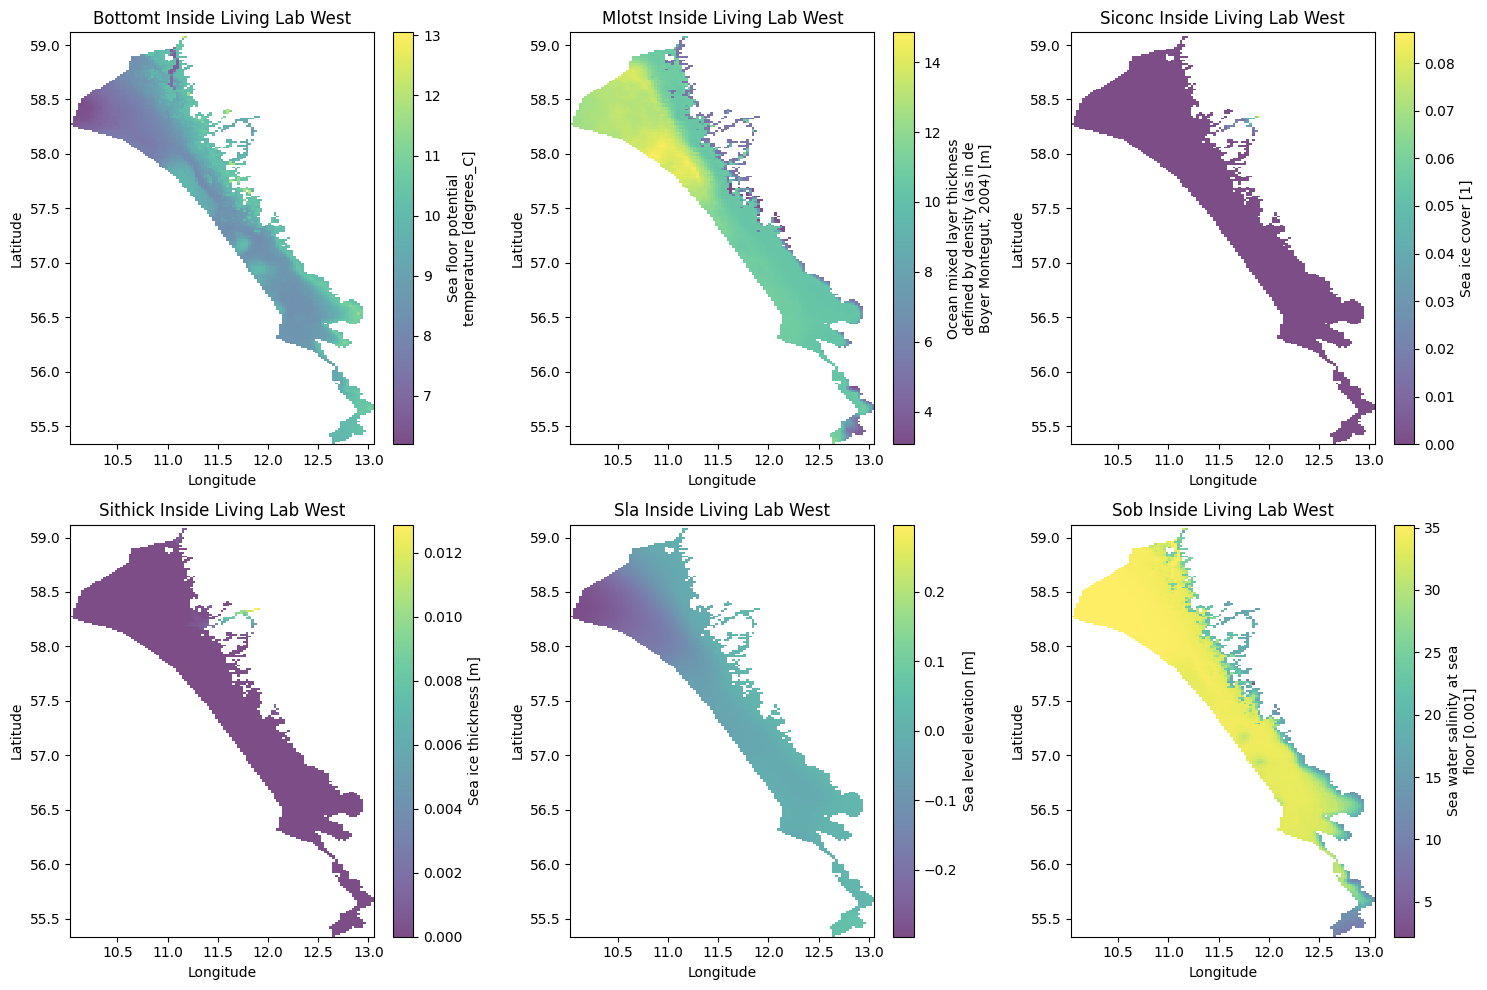

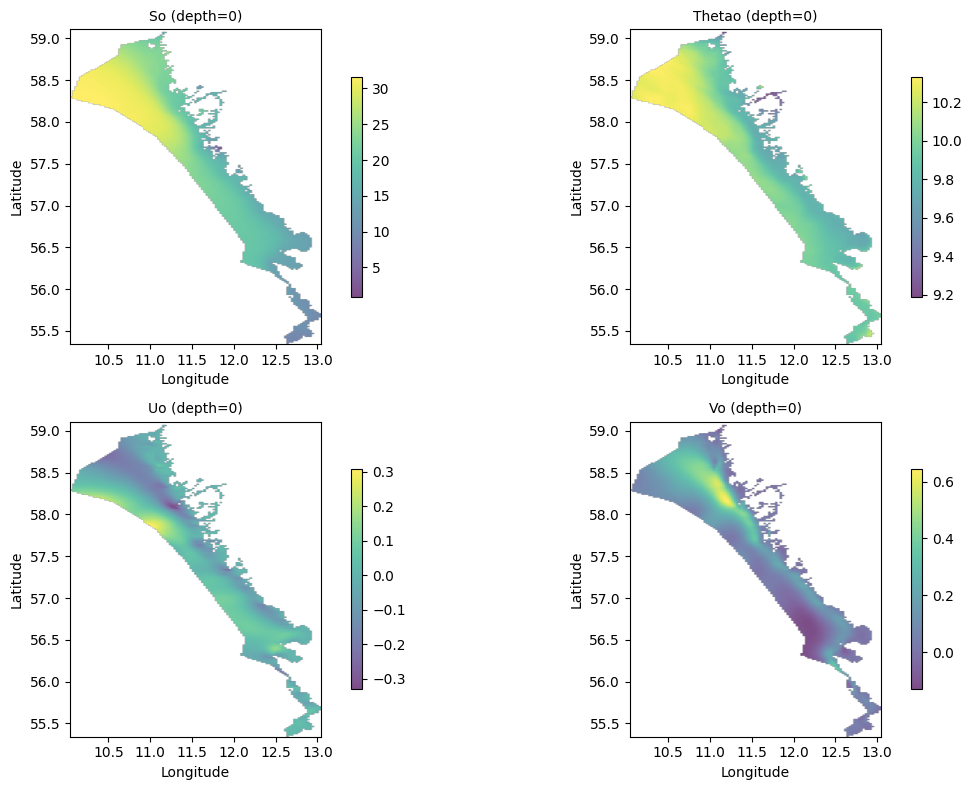

In [63]:
def plot_2D_variables_grid(var_names):
    n_vars = len(var_names)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()
    for i, var_name in enumerate(var_names):
        data_filtered = filtered_data[var_name].isel(time=0)
        mappable = data_filtered.plot(ax=axes[i], cmap='viridis', alpha=0.7, add_colorbar=True)
        axes[i].set_title(f'{var_name.capitalize()} Inside Living Lab West', fontsize=12)
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Latitude')
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

plot_2D_variables_grid(['bottomT', 'mlotst', 'siconc', 'sithick', 'sla', 'sob'])

def plot_3D_variables_grid(var_names):
    n_vars = len(var_names)
    n_cols = 2
    n_rows = (n_vars + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten()
    for i, var_name in enumerate(var_names):
        data_filtered = filtered_data[var_name].isel(time=0)
        depth_data_filtered = data_filtered.isel(depth=0).squeeze()
        lat = depth_data_filtered.coords['lat'].values
        lon = depth_data_filtered.coords['lon'].values
        im = axes[i].imshow(depth_data_filtered, cmap='viridis', alpha=0.7, origin='lower',
                            extent=[lon.min(), lon.max(), lat.min(), lat.max()])
        fig.colorbar(im, ax=axes[i], shrink=0.7)
        axes[i].set_title(f'{var_name.capitalize()} (depth=0)', fontsize=10)
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Latitude')
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

plot_3D_variables_grid(['so', 'thetao', 'uo', 'vo'])


Let's repeat the method for all the years and save the results. 
⏳ This step can be very long.

In [66]:
for year in range(2015, 2024):
    input_file = f'BAL-MYP-NEMO_PHY-AnnualMeans-{year}.nc'
    output_file = f'filtered_{input_file}'

    ds = xr.open_dataset(input_file)
    lat = ds['lat'].values
    lon = ds['lon'].values
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    coords = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))
    mask = np.array([livinglab_geometry.contains(shape({'type': 'Point', 'coordinates': (lon, lat)})) for lon, lat in coords])
    mask = mask.reshape(lon_grid.shape)
    mask_da = xr.DataArray(mask, coords=[ds['lat'], ds['lon']], dims=["lat", "lon"])
    filtered_data = ds.where(mask_da, drop=True) 
    filtered_data.to_netcdf(output_file)
    print(f'Filtered data for {year} saved to {output_file}')

Filtered data for 2015 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2015.nc
Filtered data for 2016 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2016.nc
Filtered data for 2017 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2017.nc
Filtered data for 2018 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2018.nc
Filtered data for 2019 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2019.nc
Filtered data for 2020 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2020.nc
Filtered data for 2021 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2021.nc
Filtered data for 2022 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2022.nc
Filtered data for 2023 saved to filtered_BAL-MYP-NEMO_PHY-AnnualMeans-2023.nc


### 🛠️ Filtering the Baltic Sea Biogeochemistry Reanalysis datset

This dataset is stuctured like the Baltic Sea Reanalysis datset, so we will use the same method. Let's open the dataset first and see the name of the variables.

In [68]:
input_file = 'BAL-MYP-ERGOM_BGC-AnnualMeans-2015.nc'
ds = xr.open_dataset(input_file)
ds

<xarray.Dataset> Size: 933MB
Dimensions:  (time: 1, depth: 56, lat: 774, lon: 763)
Coordinates:
  * depth    (depth) float32 224B 0.5016 1.516 2.548 3.602 ... 663.9 688.0 712.0
  * lat      (lat) float32 3kB 53.01 53.02 53.04 53.06 ... 65.86 65.87 65.89
  * lon      (lon) float32 3kB 9.042 9.069 9.097 9.125 ... 30.15 30.18 30.21
  * time     (time) datetime64[ns] 8B 2015-07-01T06:00:00
Data variables:
    chl      (time, depth, lat, lon) float32 132MB ...
    nh4      (time, depth, lat, lon) float32 132MB ...
    no3      (time, depth, lat, lon) float32 132MB ...
    nppv     (time, depth, lat, lon) float32 132MB ...
    o2       (time, depth, lat, lon) float32 132MB ...
    o2b      (time, lat, lon) float32 2MB ...
    ph       (time, depth, lat, lon) float32 132MB ...
    po4      (time, depth, lat, lon) float32 132MB ...
    spco2    (time, lat, lon) float32 2MB ...
    zsd      (time, lat, lon) float32 2MB ...
Attributes: (12/22)
    CDI:                    Climate Data Interface version 1.9.9rc1 (https://...
    Conventions:            CF-1.0
    history:                Sat Nov 09 21:06:27 2024: cdo cat /net/isilon/ifs...
    source:                 CMEMS BAL MFC NEMO model output converted to NetCDF
    institution:            Baltic MFC, PU Danish Meteorological Institute
    comment:                Data on cropped native product grid. Horizontal v...
    ...                     ...
    westernmost_longitude:  9.041542
    southernmost_latitude:  53.008297
    start_date:             2015-01-01 12:00:00
    NCO:                    netCDF Operators version 4.9.1 (Homepage = http:/...
    CDO:                    Climate Data Operators version 1.9.9rc1 (https://...
    title:                  CMEMS ERGOM annual integrated model fields

It is the exact same column names, let's copy the last code and filter the Baltic Sea Biogeochemistry Reanalysis datset.

In [69]:
for year in range(2015, 2024):
    input_file = f'BAL-MYP-ERGOM_BGC-AnnualMeans-{year}.nc'
    output_file = f'filtered_{input_file}'

    ds = xr.open_dataset(input_file)
    lat = ds['lat'].values
    lon = ds['lon'].values
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    coords = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))
    mask = np.array([livinglab_geometry.contains(shape({'type': 'Point', 'coordinates': (lon, lat)})) for lon, lat in coords])
    mask = mask.reshape(lon_grid.shape)
    mask_da = xr.DataArray(mask, coords=[ds['lat'], ds['lon']], dims=["lat", "lon"])
    filtered_data = ds.where(mask_da, drop=True) 
    filtered_data.to_netcdf(output_file)
    print(f'Filtered data for {year} saved to {output_file}')

Filtered data for 2015 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2015.nc
Filtered data for 2016 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2016.nc
Filtered data for 2017 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2017.nc
Filtered data for 2018 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2018.nc
Filtered data for 2019 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2019.nc
Filtered data for 2020 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2020.nc
Filtered data for 2021 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2021.nc
Filtered data for 2022 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2022.nc
Filtered data for 2023 saved to filtered_BAL-MYP-ERGOM_BGC-AnnualMeans-2023.nc


### 🛠️ Filtering the Bathymetry dataset

I used the same method to filter the bathymetry dataset.

In [6]:
bathymetry = xr.open_dataset('D5_2024.nc')
bathymetry

<xarray.Dataset> Size: 3GB
Dimensions:             (lon: 9484, lat: 9004, cdi_index_count: 22063)
Coordinates:
  * lon                 (lon) float64 76kB 3.498 3.499 3.501 ... 13.38 13.38
  * lat                 (lat) float64 72kB 52.5 52.5 52.5 ... 61.87 61.88 61.88
Dimensions without coordinates: cdi_index_count
Data variables:
    crs                 float64 8B ...
    elevation           (lat, lon) float32 342MB ...
    value_count         (lat, lon) float64 683MB ...
    cdi_index           (lat, lon) float64 683MB ...
    interpolation_flag  (lat, lon) float32 342MB ...
    elevation_max       (lat, lon) float32 342MB ...
    elevation_min       (lat, lon) float32 342MB ...
    stdev               (lat, lon) float32 342MB ...
    cdi_reference       (cdi_index_count) object 177kB ...
Attributes:
    dtm_convention_version:  1.0
    Conventions:             SeaDataNet_1.0 CF1.6
    title:                   The EMODnet Grid
    institution:             On behalf of the EMODnet project, https://emodne...
    source:                  source of the data can be found in the dataset o...
    references:              lastest release is DOI: https://doi.org/10.12770...
    comment:                 The data in the EMODnet Grid should not be used ...
    history:                 NetCDF file created with GGSgc NC_Makegrid versi...

This dataset has a higher resolution, so the dimentions are different : **lon**: 9484, **lat**: 9004. 

⏳ This step can be long.

In [8]:
import rasterio

In [ ]:
# Load the data
bathymetry = xr.open_dataset('D5_2024.nc')
# Extract the coordinates from the NetCDF file
lat = bathymetry['lat'].values
lon = bathymetry['lon'].values
# Create a meshgrid of lat, lon
lon_grid, lat_grid = np.meshgrid(lon, lat)
# Create a 2D array of coordinates
coords = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))
# Mask the points inside the livinglab ouest geometry
mask = np.array([livinglab_geometry.contains(shape({'type': 'Point', 'coordinates': (lon, lat)})) for lon, lat in coords])
# Reshape the mask to match the grid of the dataset
mask = mask.reshape(lon_grid.shape)
# Create an xarray DataArray for the mask with the correct dimensions and coordinates
mask_da = xr.DataArray(mask, coords=[bathymetry['lat'], bathymetry['lon']], dims=["lat", "lon"])

filtered_elevation = bathymetry['elevation'].where(mask_da, drop=True)


# # Apply the mask to the NetCDF data variables
# filtered_bathymetry = bathymetry.where(mask_da, drop=True)

In [ ]:
def plot_2D_variables_grid(var_names):
    n_vars = len(var_names)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()
    for i, var_name in enumerate(var_names):
        data_filtered = filtered_data[var_name].isel(time=0)
        mappable = data_filtered.plot(ax=axes[i], cmap='viridis', alpha=0.7, add_colorbar=True)
        axes[i].set_title(f'{var_name.capitalize()} Inside Living Lab West', fontsize=12)
        axes[i].set_xlabel('Longitude')
        axes[i].set_ylabel('Latitude')
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

plot_2D_variables_grid(list(filtered_bathymetry.data_vars.keys()))

In [ ]:
filtered_bathymetry.to_netcdf(f'filtered_bathymetry.nc')

other try

In [34]:
import rasterio.mask

def mask_elevation_to_study_area(elevation_data, study_area_geometry, target_grid_file):
    with rasterio.open(target_grid_file) as src:
        # Mask the 'elevation' data with the study area geometry
        out_image, out_transform = rasterio.mask.mask(src, [study_area_geometry], crop=True)
        out_meta = src.meta
        
        # Update metadata to match the new data dimensions and transform
        out_meta.update({
            "driver": "GTiff",
            "count": 1,
            "dtype": "float32",
            "crs": src.crs,
            "transform": out_transform,
            "width": out_image.shape[2],
            "height": out_image.shape[1]
        })
        
        # Apply the mask to the 'elevation' variable
        masked_elevation = elevation_data * out_image[0]  # Assuming a binary mask (0s and 1s)
        
        return masked_elevation

# Example: Apply the mask to the 'elevation' variable in the dataset
elevation_data = ds['elevation'].values  # Extract the 'elevation' variable
masked_elevation = mask_elevation_to_study_area(elevation_data, livinglab_geometry.geometry, 'target_grid.tif')

# Replace the 'elevation' variable with the masked elevation
ds['elevation'] = (('lat', 'lon'), masked_elevation)

C:\Users\PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\rasterio\features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'FeatureCollection', 'features': [{'id': '0', 'type': 'Feature', 'properties': {}, 'geometry': {'type': 'Polygon', 'coordinates': (((12.61361111, 55.43111111), (12.67267791, 55.46406752), (12.71666667, 55.48861111), (12.7325, 55.54027778), (12.8452209, 55.59468055), (12.874058, 55.60859827), (12.88444444, 55.61361111), (12.89833333, 55.64361111), (12.85, 55.69861111), (12.71166667, 55.82666667), (12.7032538, 55.82428947), (12.6999234, 55.83607566), (12.69789697, 55.84286104), (12.69376587, 55.8507238), (12.69371877, 55.85081344), (12.69357631, 55.85114431), (12.69153053, 55.85589554), (12.68951448, 55.85861633), (12.68889934, 55.85984014), (12.68807386, 55.86162882), (12.66153598, 55.90929957), (12.64913047, 55.9194765), (12.64664443, 55.92194928), (12.64701232, 55.93207217), (

ValueError: operands could not be broadcast together with shapes (3624,2911) (5,4) 